In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

DEFINE ALL SEEDS

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

PREPROCESSING

In [3]:
ROOT_DIR = "./img_cls_weather_dataset/weather-dataset/dataset"

# Creating classes dictionary
classes = {
    label_idx : class_name for label_idx, class_name in enumerate(sorted(os.listdir(ROOT_DIR)))
}

In [4]:
print("Classes: ", classes)

Classes:  {0: 'dew', 1: 'fogsmog', 2: 'frost', 3: 'glaze', 4: 'hail', 5: 'lightning', 6: 'rain', 7: 'rainbow', 8: 'rime', 9: 'sandstorm', 10: 'snow'}


In [5]:
# Creating a list of image paths and their corresponding labels
img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(ROOT_DIR, class_name)
    for img_name in os.listdir(class_dir):
        img_paths.append(os.path.join(class_dir, img_name))
        labels.append(label_idx)

In [6]:
# Split train, val, test
val_size = 0.2
test_size = 0.125
is_shuffle = True

x_train, x_val, y_train, y_val = train_test_split(
    img_paths, labels, test_size=val_size, random_state=seed, shuffle=is_shuffle
)

x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=test_size, random_state=seed, shuffle=is_shuffle
)

In [7]:
# Creating a list of image paths and their corresponding labels
class WeatherDataset(Dataset): # inherit from Dataset library
    def __init__(self, x, y, transform=None):
        self.img_paths = x
        self.labels = y
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]
    
# Transform img function
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3] # Remove alpha channel (RGBA) if present 
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) # HWC to CHW
    img = img / 255.0
    return img

In [8]:
# Creating datasets
train_dataset = WeatherDataset(x_train, y_train, transform=transform)
val_dataset = WeatherDataset(x_val, y_val, transform=transform)
test_dataset = WeatherDataset(x_test, y_test, transform=transform)

# Creating dataloaders
train_batch_size = 256
test_batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

BUILDING MODEL

Building Residual block

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), # stride is the same maxpooling and change the same channels
                nn.BatchNorm2d(out_channels),
            )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)

        return x

Building ResNet

In [10]:
class ResNet(nn.Module):
    # n_block_list is a list of integers. Each integer specifies how many residual blocks to use in each of the four main stages of the ResNet. 
    def __init__(self, residual_block, n_block_list, num_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_block_list[0], stride=1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_block_list[1], stride=2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_block_list[2], stride=2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_block_list[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, num_classes)
    
    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)
        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride=1)
            blocks.append(block)

        block_sequential = nn.Sequential(*blocks)
        return block_sequential
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [11]:
n_classes = len(list(classes.keys()))
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResNet(residual_block=ResidualBlock, n_block_list=[2, 2, 2, 2], num_classes=n_classes).to(device)

UTILS

In [12]:
# Evaluation function
def evaluate(model, valid_dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        valid_loader_tqdm = tqdm(valid_dataloader, desc="Validating", leave=False)
        for inputs, labels in valid_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss = sum(losses) / len(losses)
    accuracy = correct / total * 100
    return loss, accuracy

# Training function
def train(
        model, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs=10, device="cuda"
):
    train_losses = []
    valid_losses = []
    best_model_path = "./model/best_model_weather_classification.pth"

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        batch_train_losses = []
        model.train()

        train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", leave=False)
        for idx, (inputs, labels) in enumerate(train_loader_tqdm):
            inputs,labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        # Validation
        valid_loss, valid_accuracy = evaluate(model, valid_dataloader, criterion, device)
        valid_losses.append(valid_loss)
        print(
            f"Train Loss: {train_loss:.4f}, "
            f"Valid Loss: {valid_loss:.4f}, "
            f"Valid Accuracy: {valid_accuracy:.2f}%"
        )
        # Save the model
        best_validation_loss = 100
        if valid_loss < best_validation_loss:
            best_validation_loss = valid_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"INFO: New best model saved at epoch {epoch + 1} with validation loss: {best_validation_loss:.4f}")

    print("Finished Training.")
    print(f"Best model saved at '{best_model_path}' with validation loss: {best_validation_loss:.4f}")
    return train_losses, valid_losses
            

TRAINING AND VALIDATION

Epochs:  20%|██        | 1/5 [00:49<03:17, 49.39s/it]

Train Loss: 1.6694, Valid Loss: 2.6273, Valid Accuracy: 11.51%
INFO: New best model saved at epoch 1 with validation loss: 2.6273


Epochs:  40%|████      | 2/5 [01:30<02:13, 44.42s/it]

Train Loss: 1.2170, Valid Loss: 2.0526, Valid Accuracy: 32.48%
INFO: New best model saved at epoch 2 with validation loss: 2.0526


Epochs:  60%|██████    | 3/5 [02:11<01:26, 43.09s/it]

Train Loss: 1.1044, Valid Loss: 1.0908, Valid Accuracy: 61.25%
INFO: New best model saved at epoch 3 with validation loss: 1.0908


Epochs:  80%|████████  | 4/5 [02:51<00:41, 41.93s/it]

Train Loss: 0.9923, Valid Loss: 1.2680, Valid Accuracy: 57.39%
INFO: New best model saved at epoch 4 with validation loss: 1.2680


Epochs: 100%|██████████| 5/5 [03:35<00:00, 43.08s/it]

Train Loss: 0.9561, Valid Loss: 1.3533, Valid Accuracy: 54.99%
INFO: New best model saved at epoch 5 with validation loss: 1.3533
Finished Training.
Best model saved at './model/best_model_weather_classification.pth' with validation loss: 1.3533


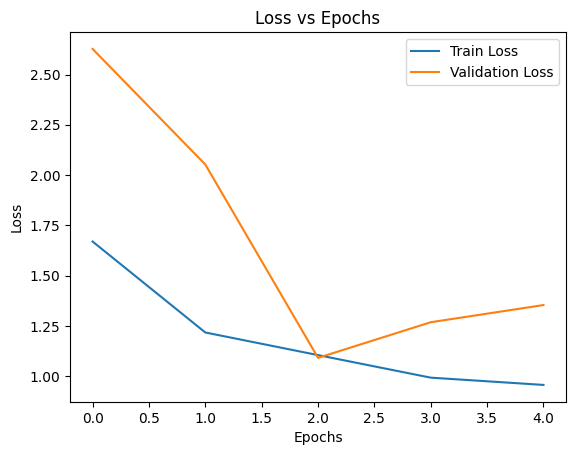

In [13]:
LEARNING_RATE = 1e-2
EPOCHS = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
train_losses, valid_losses = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=EPOCHS,
    device=device
)
# Plotting the loss
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print("Evaluation on test dataset")
print("Test accuracy", test_acc)

Evaluation on test dataset
Test accuracy 54.14847161572053
